Kolkata Knight Riders: Players analysis

In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

In [2]:
batting_2024 = pd.read_csv("kkr_batting_2024.csv")
bowling_2024 = pd.read_csv("kkr_bowling_2024.csv")

# Merge the DataFrames on the 'Player' column, using an outer join
merged_2024 = pd.merge(batting_2024, bowling_2024, on='Player', how='outer')

# Fill NaN values with 0
merged_2024.fillna(0, inplace=True)

# Display the merged DataFrame
print(merged_2024)

    POS_x                Player  Runs_scored  Mathces_played  Inns_x   NO  \
0    45.0         Andre Russell        222.0            15.0     9.0  2.0   
1    62.0  Angkrish Raghuvanshi        163.0            10.0     7.0  0.0   
2   147.0            Anukul Roy          3.0             4.0     1.0  1.0   
3     0.0          Harshit Rana          0.0             0.0     0.0  0.0   
4    95.0         Manish Pandey         42.0             1.0     1.0  0.0   
5   134.0        Mitchell Starc          9.0            14.0     5.0  3.0   
6    97.0           Nitish Rana         42.0             2.0     2.0  0.0   
7    14.0             Phil Salt        435.0            12.0    12.0  1.0   
8    86.0    Rahmanullah Gurbaz         62.0             3.0     2.0  0.0   
9    72.0       Ramandeep Singh        125.0            15.0     9.0  5.0   
10   59.0           Rinku Singh        168.0            15.0    11.0  2.0   
11   26.0          Shreyas Iyer        351.0            15.0    14.0  5.0   

In [3]:
# merged_df.to_csv("kkr_data_2024.csv")

In [4]:
data = pd.read_csv("kkr_data_2024.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          16 non-null     int64  
 1   Player              16 non-null     object 
 2   Runs_scored         16 non-null     int64  
 3   Mathces_played      16 non-null     int64  
 4   NO                  16 non-null     int64  
 5   HS                  16 non-null     int64  
 6   Batting_avg         16 non-null     float64
 7   Ballsfaced          16 non-null     int64  
 8   Batting_strikerate  16 non-null     float64
 9   100                 16 non-null     int64  
 10  50                  16 non-null     int64  
 11  4s                  16 non-null     int64  
 12  6s                  16 non-null     int64  
 13  Wkts_taken          16 non-null     int64  
 14  Overs_bowled        16 non-null     float64
 15  Runs_given          16 non-null     int64  
 16  Bowling_av

In [6]:
# players taken atleast 1 wicket
players_with_wickets = data[data['Wkts_taken'] >= 1]


In [7]:
# Players scored atleast 100 runs
players_with_runs = data[data['Runs_scored'] >= 1]

In [8]:
print("average runs scored",players_with_runs['Runs_scored'].mean())
print("average batting strikerate",players_with_runs['Batting_strikerate'].mean())
print("average wickets taken",players_with_wickets['Wkts_taken'].mean())
print("average bowling economy",players_with_wickets['Bowling_economy'].mean())

average runs scored 177.21428571428572
average batting strikerate 145.32071428571427
average wickets taken 17.333333333333332
average bowling economy 8.944999999999999


In [9]:
# Correlation matrix
cr = data[['Runs_scored','Mathces_played','Batting_avg',
           'Batting_strikerate','Wkts_taken','Bowling_economy',
           ]]

                    Runs_scored  Mathces_played  Batting_avg  \
Runs_scored            1.000000        0.546167     0.729182   
Mathces_played         0.546167        1.000000     0.214070   
Batting_avg            0.729182        0.214070     1.000000   
Batting_strikerate     0.654063        0.362864     0.781647   
Wkts_taken            -0.152718        0.198344    -0.484244   
Bowling_economy       -0.235745        0.178935    -0.538005   

                    Batting_strikerate  Wkts_taken  Bowling_economy  
Runs_scored                   0.654063   -0.152718        -0.235745  
Mathces_played                0.362864    0.198344         0.178935  
Batting_avg                   0.781647   -0.484244        -0.538005  
Batting_strikerate            1.000000   -0.520868        -0.483604  
Wkts_taken                   -0.520868    1.000000         0.954445  
Bowling_economy              -0.483604    0.954445         1.000000  


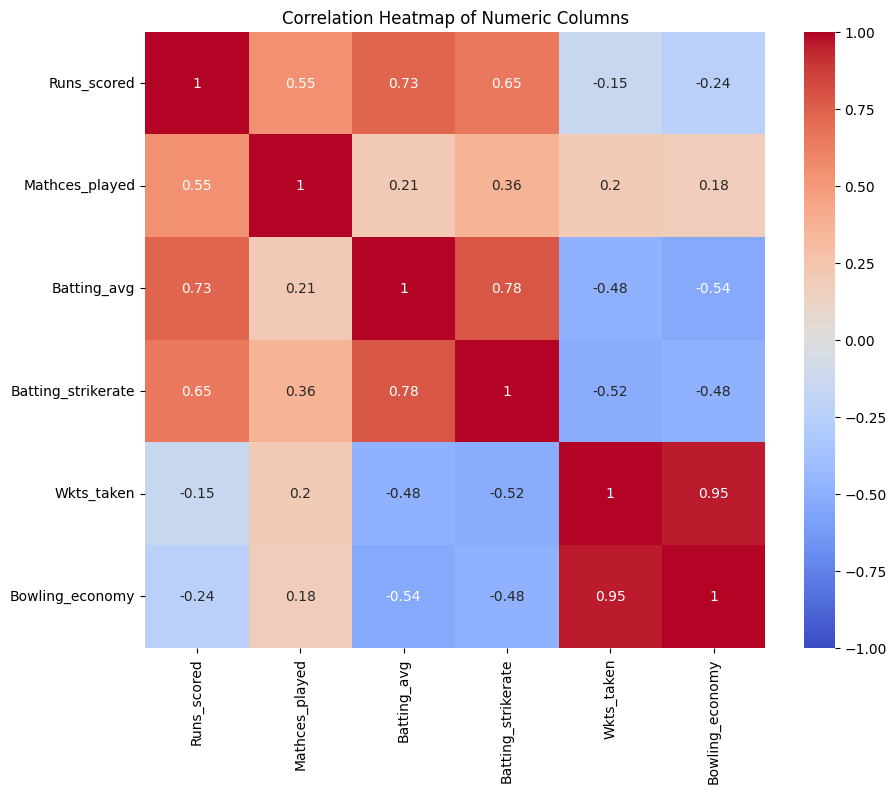

In [10]:
correlation_matrix = cr.corr()

# Print correlation matrix
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [11]:
df = data

In [12]:
# Normalize metrics
for metric in ['Runs_scored', 'Batting_avg', 'Batting_strikerate', 'Wkts_taken']:
    df[f'{metric}_norm'] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Normalize economy rate (lower is better)
df['Bowling_economy_norm'] = 1 - (df['Bowling_economy'] - df['Bowling_economy'].min()) / (df['Bowling_economy'].max() - df['Bowling_economy'].min())

# Assign weights
batting_weights = {
    'Runs_scored_norm': 0.4,
    'Batting_avg_norm': 0.3,
    'Batting_strikerate_norm': 0.3
}

bowling_weights = {
    'Wkts_taken_norm': 0.6,
    'Bowling_economy_norm': 0.4
}

# Determine player type
def determine_player_type(row):
    if row['Runs_scored'] > 100 and row['Wkts_taken'] <= 2 and row['Ballsfaced'] > 40:
        return 'Batsman'
    elif row['Wkts_taken'] > 5 and row['Runs_scored'] < 100:
        return 'Bowler'
    elif row['Wkts_taken'] >= 3 and row['Runs_scored'] > 100:
        return 'All-rounder'
    return 'Other Players'

df['Player_type'] = df.apply(determine_player_type, axis=1)

# Calculate scores based on player type
def calculate_score(row):
    if row['Player_type'] == 'Batsman':
        return (
            row['Runs_scored_norm'] * batting_weights['Runs_scored_norm'] +
            row['Batting_avg_norm'] * batting_weights['Batting_avg_norm'] +
            row['Batting_strikerate_norm'] * batting_weights['Batting_strikerate_norm']
        ) * 100
    elif row['Player_type'] == 'Bowler':
        return (
            row['Wkts_taken_norm'] * bowling_weights['Wkts_taken_norm'] +
            row['Bowling_economy_norm'] * bowling_weights['Bowling_economy_norm']
        ) * 100
    elif row['Player_type'] == 'All-rounder':
        batting_score = (
            row['Runs_scored_norm'] * batting_weights['Runs_scored_norm'] +
            row['Batting_avg_norm'] * batting_weights['Batting_avg_norm'] +
            row['Batting_strikerate_norm'] * batting_weights['Batting_strikerate_norm']
        ) * 100
        bowling_score = (
            row['Wkts_taken_norm'] * bowling_weights['Wkts_taken_norm'] +
            row['Bowling_economy_norm'] * bowling_weights['Bowling_economy_norm']
        ) * 100
        return (batting_score + bowling_score) / 2
    return 0

df['Overall_score'] = df.apply(calculate_score, axis=1)

print(df[['Player', 'Player_type', 'Overall_score']])

                  Player    Player_type  Overall_score
0          Andre Russell    All-rounder      61.345348
1   Angkrish Raghuvanshi        Batsman      51.566239
2             Anukul Roy  Other Players       0.000000
3           Harshit Rana         Bowler      60.053858
4          Manish Pandey  Other Players       0.000000
5         Mitchell Starc         Bowler      48.571429
6            Nitish Rana  Other Players       0.000000
7              Phil Salt        Batsman      88.391782
8     Rahmanullah Gurbaz  Other Players       0.000000
9        Ramandeep Singh        Batsman      60.516172
10           Rinku Singh        Batsman      48.003177
11          Shreyas Iyer        Batsman      75.920872
12          Sunil Narine    All-rounder      76.428165
13         Vaibhav Arora         Bowler      36.744311
14   Varun Chakaravarthy         Bowler      69.688973
15        Venkatesh Iyer        Batsman      83.956161


In [13]:
# df.to_csv("check.csv")

In [14]:
# Sort the DataFrame by 'Overall_score' in descending order
sorted_df = df.sort_values(by="Overall_score", ascending=False)

# Display the player names and their overall scores
for index, row in sorted_df.iterrows():
    print(f"{row['Player']}, Overall Score: {row['Overall_score']}")

Phil Salt, Overall Score: 88.3917817396278
Venkatesh Iyer, Overall Score: 83.95616109986737
Sunil Narine, Overall Score: 76.42816529147069
Shreyas Iyer, Overall Score: 75.92087178496665
Varun Chakaravarthy, Overall Score: 69.68897266729502
Andre Russell, Overall Score: 61.345348244432685
Ramandeep Singh, Overall Score: 60.516171909614535
Harshit Rana, Overall Score: 60.053857546788734
Angkrish Raghuvanshi, Overall Score: 51.56623938394726
Mitchell Starc, Overall Score: 48.57142857142857
Rinku Singh, Overall Score: 48.003176636318656
Vaibhav Arora, Overall Score: 36.74431129662044
Anukul Roy, Overall Score: 0.0
Manish Pandey, Overall Score: 0.0
Nitish Rana, Overall Score: 0.0
Rahmanullah Gurbaz, Overall Score: 0.0


Now take data of 2022,2023,2024 . combine all those data and give points to all players.

In [15]:
# 2022 data combine

batting_2022 = pd.read_csv("kkr_batting_2022.csv")
bowling_2022 = pd.read_csv("kkr_bowling_2022.csv")

# Merge the DataFrames on the 'Player' column, using an outer join
merged_2022 = pd.merge(batting_2022, bowling_2022, on='Player', how='outer')

# Fill NaN values with 0
merged_2022.fillna(0, inplace=True)

# Display the merged DataFrame
print(merged_2022)

    POS_x               Player Team_x  Runs_x  Mat_x  Inns_x   NO   HS  Avg_x  \
0    76.0          Aaron Finch    KKR    86.0    5.0     5.0  0.0   58  17.20   
1   149.0       Abhijeet Tomar    KKR     4.0    1.0     1.0  0.0    4   4.00   
2    65.0       Ajinkya Rahane    KKR   133.0    7.0     7.0  0.0   44  19.00   
3   141.0            Aman Khan    KKR     5.0    1.0     1.0  0.0    5   5.00   
4    24.0        Andre Russell    KKR   335.0   14.0    12.0  3.0  70*  37.22   
5     0.0           Anukul Roy      0     0.0    0.0     0.0  0.0    0      0   
6   115.0          B Indrajith    KKR    21.0    3.0     3.0  0.0   15   7.00   
7   154.0         Harshit Rana    KKR     2.0    2.0     2.0  1.0    2   2.00   
8    21.0          Nitish Rana    KKR   361.0   14.0    14.0  1.0   57  27.77   
9    82.0          Pat Cummins    KKR    63.0    5.0     5.0  1.0  56*  15.75   
10  134.0         Rasikh Salam    KKR     7.0    2.0     1.0  0.0    7   7.00   
11   56.0          Rinku Sin

In [16]:
# merged_2022.to_csv("check_2022.csv")

In [17]:
# 2023 data combine

batting_2023 = pd.read_csv("kkr_batting_2023.csv")
bowling_2023 = pd.read_csv("kkr_bowling_2023.csv")

# Merge the DataFrames on the 'Player' column, using an outer join
merged_2023 = pd.merge(batting_2023, bowling_2023, on='Player', how='outer')

# Fill NaN values with 0
merged_2023.fillna(0, inplace=True)

# Display the merged DataFrame
print(merged_2023)

    POS_x               Player Team_x  Runs_x  Mat_x  Inns_x   NO   HS  Avg_x  \
0    46.0        Andre Russell    KKR   227.0   14.0    14.0  3.0   42  20.64   
1   106.0           Anukul Roy    KKR    23.0    4.0     4.0  2.0  13*  11.50   
2   109.0          David Wiese    KKR    21.0    3.0     3.0  2.0  12*  21.00   
3     0.0         Harshit Rana      0     0.0    0.0     0.0  0.0    0      0   
4    76.0   Jagadeesan Narayan    KKR    89.0    6.0     6.0  0.0   36  14.83   
5    33.0            Jason Roy    KKR   285.0    8.0     8.0  0.0   61  35.63   
6     0.0   Kulwant Khejroliya      0     0.0    0.0     0.0  0.0    0      0   
7   146.0           Litton Das    KKR     4.0    1.0     1.0  0.0    4   4.00   
8     0.0      Lockie Ferguson      0     0.0    0.0     0.0  0.0    0      0   
9   125.0        Mandeep Singh    KKR    14.0    3.0     3.0  0.0   12   4.67   
10   14.0          Nitish Rana    KKR   413.0   14.0    14.0  1.0   75  31.77   
11   47.0   Rahmanullah Gurb

In [18]:
# Checking and correcting data
# merged_2022.to_csv("check_2022.csv")

In [19]:
# here the matched played are in duplicaqtes , removing duplicates
# Create the new column
# data_2024 = pd.read_csv("cleaned_2024.csv")

# data_2024['Matches_in_2024'] = data_2024[['Mathces_played_2024_bt', 'Matches_played_2024_bb']].max(axis=1)

# # Optionally drop the old columns
# data_2024.drop(['Mathces_played_2024_bt', 'Matches_played_2024_bb'], axis=1, inplace=True)



In [20]:
# Read the cleaned data
data2022 = pd.read_csv("data_2022.csv")
data2023 = pd.read_csv("data_2023.csv")
data2024 = pd.read_csv("data_2024.csv")

In [21]:
# Merge all 3 years dataframes
# Merge the DataFrames on the 'Player' column, using an outer join
merged_23_22 = pd.merge(data2022,data2023, on='Player', how='outer')

In [22]:
merged_df = pd.merge(merged_23_22,data2024, on='Player', how='outer')

In [23]:
# Fill NaN values with 0
merged_df.fillna(0, inplace=True)

In [24]:
# merged_df.to_csv("check_all.csv")

In [25]:
# Read complete data of KKR

full_data = pd.read_csv("complete_3_years_data_kkr.csv")


full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               37 non-null     int64  
 1   Player                   37 non-null     object 
 2   Runs_scored_2022         37 non-null     int64  
 3   HS_2022                  37 non-null     int64  
 4   Batting_avg_2022         37 non-null     float64
 5   Ballsfaced_2022          37 non-null     int64  
 6   Batting_strikerate_2022  37 non-null     float64
 7   4s_2022                  37 non-null     int64  
 8   6s_2022                  37 non-null     int64  
 9   Wkts_taken_2022          37 non-null     int64  
 10  Overs_bowled_2022        37 non-null     float64
 11  Runs_given_2022          37 non-null     int64  
 12  Bowling_avg_2022         37 non-null     float64
 13  Bowling_economy_2022     37 non-null     float64
 14  bowling_strikerate_2022  37 

In [26]:
Feature_add = full_data

In [27]:
Feature_add['Total matches'] = Feature_add['Matches_in_2022'] + Feature_add['Matches_in_2023'] + Feature_add['Matches_in_2024']

In [28]:
Feature_add['Total_runs_scored'] = Feature_add['Runs_scored_2022'] + Feature_add['Runs_scored_2023'] + Feature_add['Runs_scored_2024']

In [42]:
# Function to calculate average strike rate
def overall_batting_avg(row):
    rates = [row['Batting_avg_2022'], row['Batting_avg_2023'], row['Batting_avg_2024']]
    valid_rates = [rate for rate in rates if rate != 0]
    return np.mean(valid_rates) if valid_rates else 0

# Apply the function to each row
Feature_add['Total_batting_average'] = Feature_add.apply(overall_batting_avg, axis=1)


In [30]:
Feature_add['Total_wickets_taken'] = (Feature_add['Wkts_taken_2022']) + (Feature_add['Wkts_taken_2023']) + (Feature_add['Wkts_taken_2024'])

In [37]:
# Function to calculate average strike rate
def avg_economy(row):
    rates = [row['Bowling_economy_2022'], row['Bowling_economy_2023'], row['Bowling_economy_2024']]
    valid_rates = [rate for rate in rates if rate != 0]
    return np.mean(valid_rates) if valid_rates else 0

# Apply the function to each row
Feature_add['Overall_economy'] = Feature_add.apply(avg_economy, axis=1)



In [32]:
Feature_add['Total_balls_faced'] = Feature_add['Ballsfaced_2022'] + Feature_add['Ballsfaced_2023'] + Feature_add['Ballsfaced_2024']

In [33]:
Feature_add['Total_runs_given'] = Feature_add['Runs_given_2022'] + Feature_add['Runs_given_2023'] + Feature_add['Runs_given_2024']

In [34]:
# Function to calculate average strike rate
def avg_strike_rate(row):
    rates = [row['Batting_strikerate_2022'], row['Batting_strikerate_2023'], row['Batting_strikerate_2024']]
    valid_rates = [rate for rate in rates if rate != 0]
    return np.mean(valid_rates) if valid_rates else 0

# Apply the function to each row
Feature_add['Avg_Strike_Rate'] = Feature_add.apply(avg_strike_rate, axis=1)


In [44]:
Modified_data = Feature_add[['Player','Total matches','Total_runs_scored','Total_balls_faced','Avg_Strike_Rate','Total_batting_average','Total_wickets_taken','Overall_economy','Total_runs_given']]

In [81]:
# Modified_data.to_csv("check_all.csv")

In [69]:
Modified_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player                 37 non-null     object 
 1   Total matches          37 non-null     int64  
 2   Total_runs_scored      37 non-null     int64  
 3   Total_balls_faced      37 non-null     int64  
 4   Avg_Strike_Rate        37 non-null     float64
 5   Total_batting_average  37 non-null     float64
 6   Total_wickets_taken    37 non-null     int64  
 7   Overall_economy        37 non-null     float64
 8   Total_runs_given       37 non-null     int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.7+ KB


In [79]:
Modified_data.drop(columns=['Total_runs_scored_norm','Total_batting_average_norm',
                            'Avg_Strike_Rate_norm','Total_wickets_taken_norm','Bowling_economy_norm',
                            'Player_type'], axis=1, inplace=True)

C:\Users\niran\AppData\Local\Temp\ipykernel_13788\3870774521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Modified_data.drop(columns=['Total_runs_scored_norm','Total_batting_average_norm',


In [80]:
Modified_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player                 37 non-null     object 
 1   Total matches          37 non-null     int64  
 2   Total_runs_scored      37 non-null     int64  
 3   Total_balls_faced      37 non-null     int64  
 4   Avg_Strike_Rate        37 non-null     float64
 5   Total_batting_average  37 non-null     float64
 6   Total_wickets_taken    37 non-null     int64  
 7   Overall_economy        37 non-null     float64
 8   Total_runs_given       37 non-null     int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.7+ KB


                       Total matches  Total_runs_scored  Total_balls_faced  \
Total matches               1.000000           0.768883           0.753506   
Total_runs_scored           0.768883           1.000000           0.993482   
Total_balls_faced           0.753506           0.993482           1.000000   
Avg_Strike_Rate             0.167126           0.370730           0.332912   
Total_batting_average       0.323426           0.677057           0.663404   
Total_wickets_taken         0.645127           0.101201           0.056800   
Overall_economy             0.189764          -0.140786          -0.165150   
Total_runs_given            0.615116           0.039826          -0.001123   

                       Avg_Strike_Rate  Total_batting_average  \
Total matches                 0.167126               0.323426   
Total_runs_scored             0.370730               0.677057   
Total_balls_faced             0.332912               0.663404   
Avg_Strike_Rate               1.00000

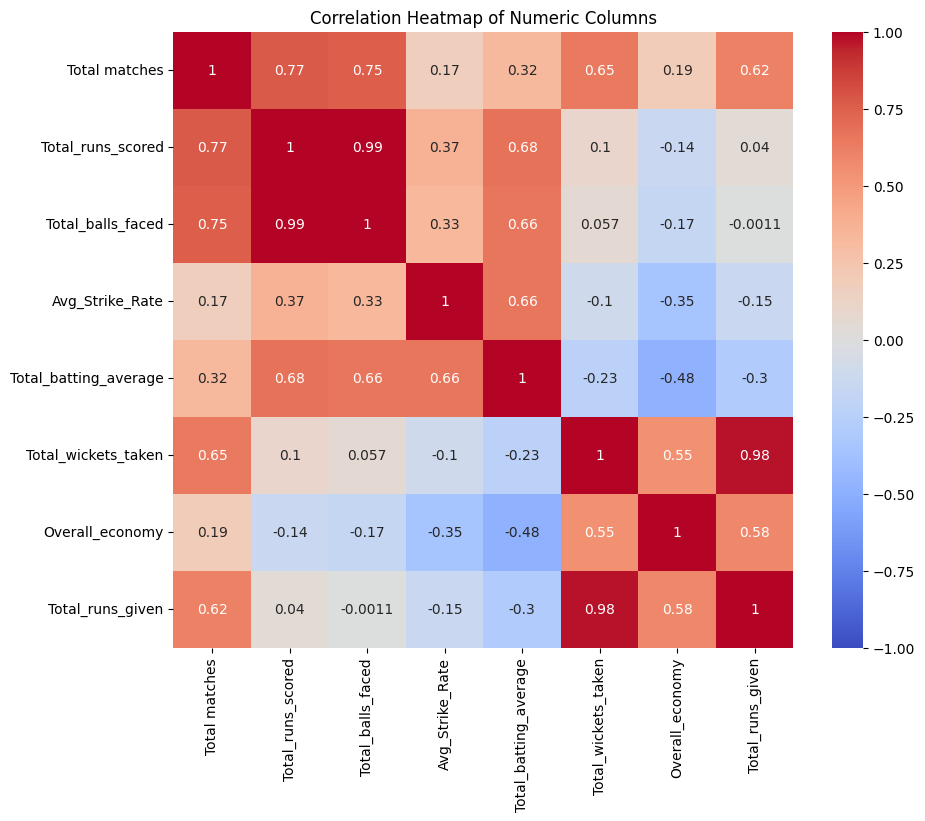

In [70]:
cr_data = Modified_data[['Total matches','Total_runs_scored','Total_balls_faced','Avg_Strike_Rate','Total_batting_average','Total_wickets_taken','Overall_economy','Total_runs_given']]
cf = cr_data.corr()

# Print correlation matrix
print(cf)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [75]:
# Now rank the players and determine the player type

# Normalize metrics
for metric in ['Total_runs_scored', 'Total_batting_average', 'Avg_Strike_Rate', 'Total_wickets_taken']:
    Modified_data[f'{metric}_norm'] = (Modified_data[metric] - Modified_data[metric].min()) / (Modified_data[metric].max() - Modified_data[metric].min())

# Normalize economy rate (lower is better)
Modified_data['Bowling_economy_norm'] = 1 - (Modified_data['Overall_economy'] - Modified_data['Overall_economy'].min()) / (Modified_data['Overall_economy'].max() - Modified_data['Overall_economy'].min())

# Assign weights
batting_weights = {
    'Total_runs_scored_norm': 0.4,
    'Total_batting_average_norm': 0.3,
    'Avg_Strike_Rate_norm': 0.3
}

bowling_weights = {
    'Total_wickets_taken_norm': 0.6,
    'Overall_economy_norm': 0.4
}

# Determine player type
def determine_player_type(row):
    if row['Total_runs_scored'] >= 100 and row['Total_wickets_taken'] <= 2 and row['Total_balls_faced'] >= 40:
        return 'Batsman'
    elif row['Total_wickets_taken'] > 5 and row['Total_runs_scored'] <= 100:
        return 'Bowler'
    elif row['Total_wickets_taken'] >= 3 and row['Total_runs_scored'] >= 100:
        return 'All-rounder'
    return 'Other Players'

Modified_data['Player_type'] = Modified_data.apply(determine_player_type, axis=1)

# Calculate scores based on player type
def calculate_score(row):
    if row['Player_type'] == 'Batsman':
        return (
            row['Total_runs_scored_norm'] * batting_weights['Total_runs_scored_norm'] +
            row['Total_batting_average_norm'] * batting_weights['Total_batting_average_norm'] +
            row['Avg_Strike_Rate_norm'] * batting_weights['Avg_Strike_Rate_norm']
        ) * 100
    elif row['Player_type'] == 'Bowler':
        return (
            row['Total_wickets_taken_norm'] * bowling_weights['Total_wickets_taken_norm'] +
            row['Overall_economy_norm'] * bowling_weights['Overall_economy_norm']
        ) * 100
    elif row['Player_type'] == 'All-rounder':
        batting_score = (
            row['Total_runs_scored_norm'] * batting_weights['Total_runs_scored_norm'] +
            row['Total_batting_average_norm'] * batting_weights['Total_batting_average_norm'] +
            row['Avg_Strike_Rate_norm'] * batting_weights['Avg_Strike_Rate_norm']
        ) * 100
        bowling_score = (
            row['Total_wickets_taken_norm'] * bowling_weights['Total_wickets_taken_norm'] +
            row['Overall_economy_norm'] * bowling_weights['Overall_economy_norm']
        ) * 100
        return (batting_score + bowling_score) / 2
    return 0

Modified_data['Overall_score'] = Modified_data.apply(calculate_score, axis=1)

print(Modified_data[['Player', 'Player_type', 'Overall_score']])

C:\Users\niran\AppData\Local\Temp\ipykernel_13788\1515956819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Modified_data[f'{metric}_norm'] = (Modified_data[metric] - Modified_data[metric].min()) / (Modified_data[metric].max() - Modified_data[metric].min())
C:\Users\niran\AppData\Local\Temp\ipykernel_13788\1515956819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Modified_data[f'{metric}_norm'] = (Modified_data[metric] - Modified_data[metric].min()) / (Modified_data[metric].max() - Modified_data[m

KeyError: 'Overall_economy_norm'

In [83]:
# Assuming your data is in a DataFrame called 'data'
data = Modified_data

# Normalize metrics
metrics_to_normalize = ['Total_runs_scored', 'Total_batting_average', 'Avg_Strike_Rate', 'Total_wickets_taken']
for metric in metrics_to_normalize:
    data[f'{metric}_norm'] = (data[metric] - data[metric].min()) / (data[metric].max() - data[metric].min())

# Normalize economy rate (lower is better)
data['Overall_economy_norm'] = 1 - (data['Overall_economy'] - data['Overall_economy'].min()) / (data['Overall_economy'].max() - data['Overall_economy'].min())

# Assign weights
batting_weights = {
    'Total_runs_scored_norm': 0.4,
    'Total_batting_average_norm': 0.3,
    'Avg_Strike_Rate_norm': 0.3
}

bowling_weights = {
    'Total_wickets_taken_norm': 0.6,
    'Overall_economy_norm': 0.4
}

# Determine player type
def determine_player_type(row):
    if row['Total_runs_scored'] >= 100 and row['Total_wickets_taken'] <= 2 and row['Total_balls_faced'] >= 40:
        return 'Batsman'
    elif row['Total_wickets_taken'] > 5 and row['Total_runs_scored'] <= 100:
        return 'Bowler'
    elif row['Total_wickets_taken'] >= 3 and row['Total_runs_scored'] >= 100:
        return 'All-rounder'
    return 'Other Players'

data['Player_type'] = data.apply(determine_player_type, axis=1)

# Calculate scores based on player type
def calculate_score(row):
    if row['Player_type'] == 'Batsman':
        return sum(row[metric] * weight for metric, weight in batting_weights.items()) * 100
    elif row['Player_type'] == 'Bowler':
        return sum(row[metric] * weight for metric, weight in bowling_weights.items()) * 100
    elif row['Player_type'] == 'All-rounder':
        batting_score = sum(row[metric] * weight for metric, weight in batting_weights.items()) * 100
        bowling_score = sum(row[metric] * weight for metric, weight in bowling_weights.items()) * 100
        return (batting_score + bowling_score) / 2
    return 0

data['Overall_score'] = data.apply(calculate_score, axis=1)

# Rank players within each category
data['Rank'] = data.groupby('Player_type')['Overall_score'].rank(ascending=False, method='min')

# Sort the dataframe by Player_type and Rank
ranked_data = data.sort_values(['Player_type', 'Rank'])

# Display the ranked players
for player_type in ranked_data['Player_type'].unique():
    print(f"\n## {player_type}")
    players = ranked_data[ranked_data['Player_type'] == player_type]
    for _, player in players.iterrows():
        print(f"{player['Rank']:.0f}. {player['Player']} (Score: {player['Overall_score']:.2f})")


## All-rounder
1. Andre Russell (Score: 70.02)
2. Sunil Narine (Score: 60.60)
3. Nitish Rana (Score: 44.85)
4. Shardul Thakur (Score: 26.92)

## Batsman
1. Rinku Singh (Score: 78.01)
2. Venkatesh Iyer (Score: 77.53)
3. Shreyas Iyer (Score: 72.49)
4. Phil Salt (Score: 67.25)
5. Jason Roy (Score: 54.70)
6. Ramandeep Singh (Score: 50.59)
7. Rahmanullah Gurbaz (Score: 45.87)
8. Angkrish Raghuvanshi (Score: 41.20)
9. Sam Billings (Score: 38.31)
10. Ajinkya Rahane (Score: 31.01)

## Bowler
1. Varun Chakaravarthy (Score: 77.70)
2. Harshit Rana (Score: 46.69)
3. Umesh Yadav (Score: 38.67)
4. Vaibhav Arora (Score: 35.60)
5. Mitchell Starc (Score: 32.95)
6. Tim Southee (Score: 31.96)
7. Suyash Sharma (Score: 30.46)
8. Pat Cummins (Score: 19.99)

## Other Players
1. Aaron Finch (Score: 0.00)
1. Abhijeet Tomar (Score: 0.00)
1. Aman Khan (Score: 0.00)
1. Anukul Roy (Score: 0.00)
1. B Indrajith (Score: 0.00)
1. David Wiese (Score: 0.00)
1. Jagadeesan Narayan (Score: 0.00)
1. Kulwant Khejroliya (Sco

C:\Users\niran\AppData\Local\Temp\ipykernel_13788\210444955.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{metric}_norm'] = (data[metric] - data[metric].min()) / (data[metric].max() - data[metric].min())
C:\Users\niran\AppData\Local\Temp\ipykernel_13788\210444955.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{metric}_norm'] = (data[metric] - data[metric].min()) / (data[metric].max() - data[metric].min())
C:\Users\niran\AppData\Local\Temp\ipykernel_13788\210444955.py:7: SettingWithC

In [90]:
data[['Player','Player_type','Overall_score']].to_csv("kkr_tam_score.csv")

In [95]:
# now filter players who played 2024 season
check_2024 = merged_2024['Player'].to_list()

players_2024 = data[data['Player'].isin(check_2024)]
players_2024.to_csv("2024_only.csv")

In [96]:
players_2024.columns.to_list()

['Player',
 'Total matches',
 'Total_runs_scored',
 'Total_balls_faced',
 'Avg_Strike_Rate',
 'Total_batting_average',
 'Total_wickets_taken',
 'Overall_economy',
 'Total_runs_given',
 'Total_runs_scored_norm',
 'Total_batting_average_norm',
 'Avg_Strike_Rate_norm',
 'Total_wickets_taken_norm',
 'Overall_economy_norm',
 'Player_type',
 'Overall_score',
 'Rank']

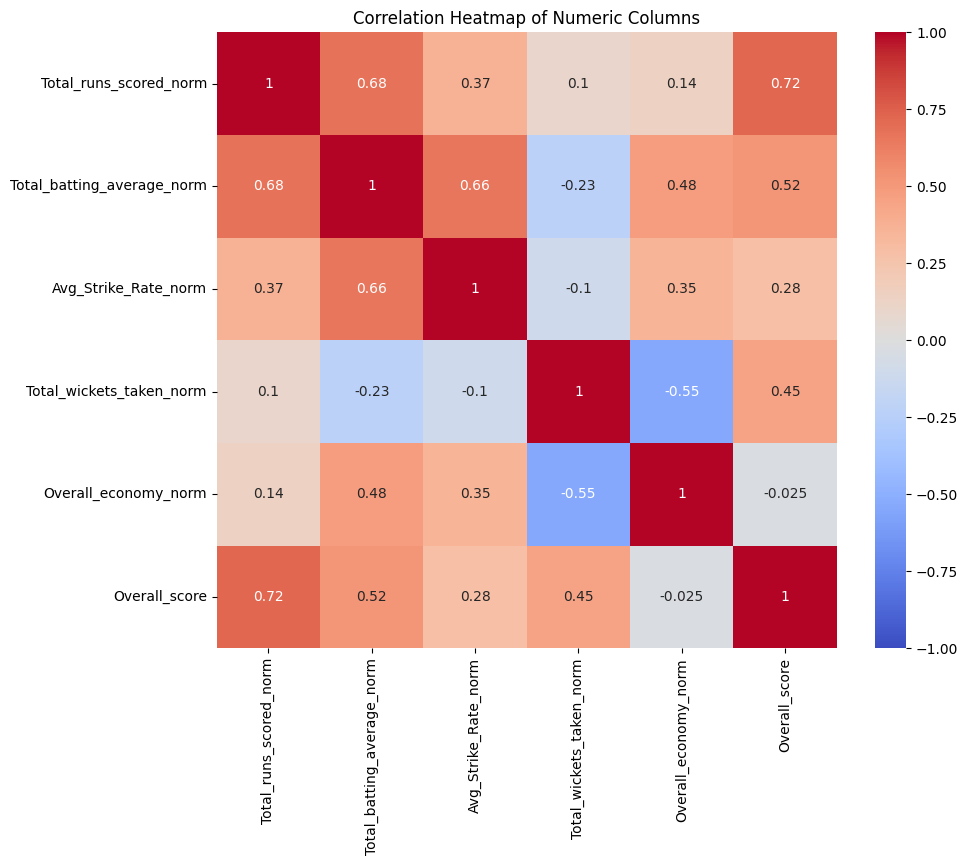

In [101]:
cr_data_2024 = Modified_data[
    [
 'Total_runs_scored_norm',
 'Total_batting_average_norm',
 'Avg_Strike_Rate_norm',
 'Total_wickets_taken_norm',
 'Overall_economy_norm',
 'Overall_score']
    ]
cf_2024 = cr_data_2024.corr()


# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf_2024, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()